In [1]:
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df=pd.read_csv("/content/drive/MyDrive/CCFD/fraudTrain.csv")

**Undersampling Code**

In [4]:
from sklearn.utils import resample

In [5]:
df_majority = df[df['is_fraud'] == 0]   # normal
df_minority = df[df['is_fraud'] == 1]   # fraud


In [6]:
df_majority_under = resample(
    df_majority,
    replace=False,                 # no replacement
    n_samples=len(df_minority),    # match minority class count
    random_state=42                # for reproducibility
)


In [7]:
df_balanced = pd.concat([df_majority_under, df_minority])

In [8]:
print(df_balanced['is_fraud'].value_counts())

is_fraud
0    7506
1    7506
Name: count, dtype: int64


In [9]:
df_balanced.to_csv("balanced_fraud_dataset.csv", index=False)

**Feature Selection + Extraction + Encoding**

In [10]:
from sklearn.preprocessing import LabelEncoder

In [11]:
df = df_balanced.copy()

In [12]:
features = [
    'amt', 'job', 'category', 'merchant',
    'lat', 'long', 'merch_lat', 'merch_long',
    'trans_date_trans_time'
]


In [13]:
df = df[features + ['is_fraud']]

In [14]:
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

df['hour'] = df['trans_date_trans_time'].dt.hour
df['day'] = df['trans_date_trans_time'].dt.day
df['month'] = df['trans_date_trans_time'].dt.month
df['day_of_week'] = df['trans_date_trans_time'].dt.dayofweek

In [15]:
def time_of_day(h):
    if h < 6: return 'night'
    elif h < 12: return 'morning'
    elif h < 18: return 'afternoon'
    else: return 'evening'

df['time_of_day'] = df['hour'].apply(time_of_day)

In [16]:
df = df.drop(columns=['trans_date_trans_time'])

In [40]:
cat_cols = ['job', 'category', 'merchant', 'time_of_day']
label_encoders = {} # Initialize dictionary to store separate LabelEncoders

In [41]:
for col in cat_cols:
    label_encoders[col] = LabelEncoder() # Create a new LabelEncoder for each column
    df[col] = label_encoders[col].fit_transform(df[col])

In [19]:
X = df.drop(columns=['is_fraud'])
y = df['is_fraud']

In [20]:
print("Final Feature Columns:")
print(X.columns)

Final Feature Columns:
Index(['amt', 'job', 'category', 'merchant', 'lat', 'long', 'merch_lat',
       'merch_long', 'hour', 'day', 'month', 'day_of_week', 'time_of_day'],
      dtype='object')


**Train–Test Split**

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report
)
from xgboost import XGBClassifier

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

**Training**

In [24]:
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

In [25]:
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
xgb_proba = xgb.predict_proba(X_test)[:, 1]

In [26]:
def evaluate_model(name, y_true, y_pred, y_proba):
    print(f"\n====================== {name} ======================")

    # Metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_proba)

    print(f"Accuracy      : {acc:.4f}")
    print(f"Precision     : {prec:.4f}")
    print(f"Recall        : {rec:.4f}")
    print(f"F1 Score      : {f1:.4f}")
    print(f"ROC-AUC Score : {roc:.4f}")

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))


In [27]:
evaluate_model("XGBoost", y_test, xgb_pred, xgb_proba)


====================== XGBoost ======================
Accuracy      : 0.9768
Precision     : 0.9766
Recall        : 0.9771
F1 Score      : 0.9768
ROC-AUC Score : 0.9966

Confusion Matrix:
[[1833   44]
 [  43 1833]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1877
           1       0.98      0.98      0.98      1876

    accuracy                           0.98      3753
   macro avg       0.98      0.98      0.98      3753
weighted avg       0.98      0.98      0.98      3753



### Visualizing Confusion Matrices

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

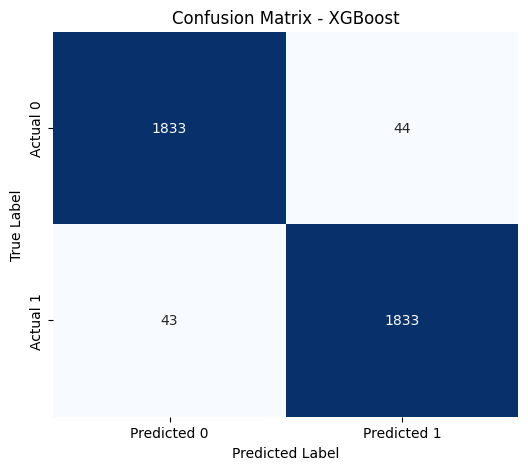

In [29]:
plot_confusion_matrix(y_test, xgb_pred, "XGBoost")


### Feature Importance Analysis

/tmp/ipython-input-3236716938.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')


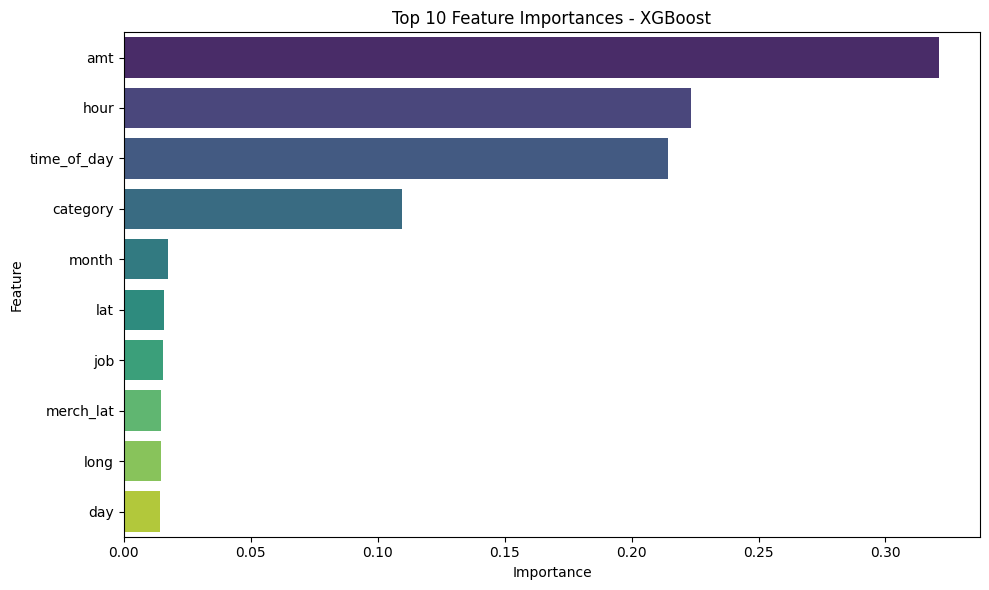

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_feature_importance(model, feature_names, model_name):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = model.coef_[0] # For linear models, often get coefficients
    else:
        print(f"Model {model_name} does not have feature_importances_ or coef_ attribute.")
        return

    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')
    plt.title(f'Top 10 Feature Importances - {model_name}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

# Get feature names from X_train
feature_names = X_train.columns.tolist()

# Plot feature importance for XGBoost
plot_feature_importance(xgb, feature_names, "XGBoost")


**Random Forest Classifier**

In [31]:
from sklearn.ensemble import RandomForestClassifier

In [32]:
rf_classifier = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    random_state=42,
    class_weight='balanced' # To handle class imbalance if any, though we already undersampled
)

rf_classifier.fit(X_train, y_train)
rf_pred = rf_classifier.predict(X_test)
rf_proba = rf_classifier.predict_proba(X_test)[:, 1]

In [33]:
evaluate_model("Random Forest", y_test, rf_pred, rf_proba)


====================== Random Forest ======================
Accuracy      : 0.9590
Precision     : 0.9654
Recall        : 0.9520
F1 Score      : 0.9587
ROC-AUC Score : 0.9904

Confusion Matrix:
[[1813   64]
 [  90 1786]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1877
           1       0.97      0.95      0.96      1876

    accuracy                           0.96      3753
   macro avg       0.96      0.96      0.96      3753
weighted avg       0.96      0.96      0.96      3753



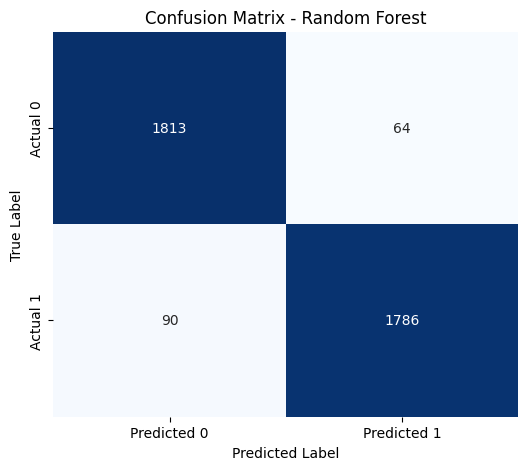

In [34]:
plot_confusion_matrix(y_test, rf_pred, "Random Forest")

/tmp/ipython-input-3236716938.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')


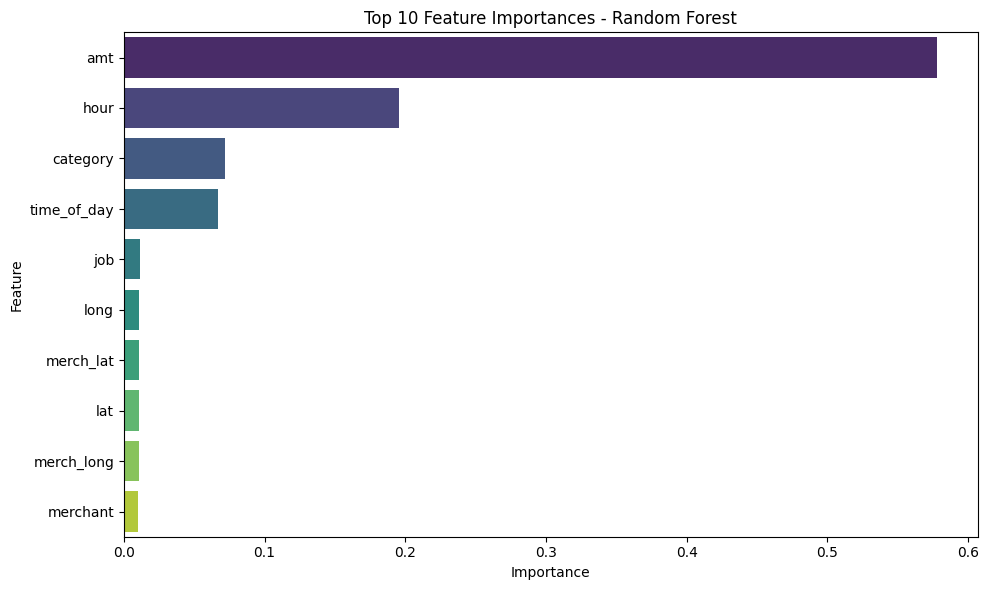

In [35]:
plot_feature_importance(rf_classifier, feature_names, "Random Forest")

**Save The Model**

In [ ]:
import joblib

joblib.dump(rf_classifier, "/content/drive/MyDrive/CCFD/random_forest_fraud_model.pkl")
print("Random Forest model saved successfully in Google Drive!")

Random Forest model saved successfully in Google Drive!


In [ ]:
import joblib

joblib.dump(xgb, "/content/drive/MyDrive/CCFD/xgboost_fraud_model.pkl")


print("Models saved successfully in Google Drive!")


In [39]:
sample_job = df['job'].sample(1).iloc[0]
sample_category = df['category'].sample(1).iloc[0]
sample_merchant = df['merchant'].sample(1).iloc[0]
sample_time_of_day = df['time_of_day'].sample(1).iloc[0]

example_job_str = "engineer"
example_category_str = "shopping_net"
example_merchant_str = "Walmart"
example_hour = 10
example_time_of_day_str = time_of_day(example_hour)


new_data = pd.DataFrame({
    'amt': [50.0],
    'job': [df['job'].sample(1).iloc[0]],
    'category': [df['category'].sample(1).iloc[0]],
    'merchant': [df['merchant'].sample(1).iloc[0]],
    'lat': [33.7],
    'long': [-84.4],
    'merch_lat': [33.75],
    'merch_long': [-84.45],
    'hour': [10],
    'day': [15],
    'month': [7],
    'day_of_week': [3],
    'time_of_day': [df['time_of_day'].sample(1).iloc[0]]
}, index=[0])

print("New Data Point (using existing encoded values for categories):\n", new_data)

# Predict with Random Forest
rf_new_pred = rf_classifier.predict(new_data)
rf_new_proba = rf_classifier.predict_proba(new_data)[:, 1]
print(f"\nRandom Forest Prediction: {'Fraud' if rf_new_pred[0] == 1 else 'Not Fraud'} (Probability: {rf_new_proba[0]:.4f})")

# Predict with XGBoost
xgb_new_pred = xgb.predict(new_data)
xgb_new_proba = xgb.predict_proba(new_data)[:, 1]
print(f"XGBoost Prediction: {'Fraud' if xgb_new_pred[0] == 1 else 'Not Fraud'} (Probability: {xgb_new_proba[0]:.4f})")

New Data Point (using existing encoded values for categories):
     amt  job  category  merchant   lat  long  merch_lat  merch_long  hour  \
0  50.0  330        11       217  33.7 -84.4      33.75      -84.45    10   

   day  month  day_of_week  time_of_day  
0   15      7            3            1  

Random Forest Prediction: Not Fraud (Probability: 0.0529)
XGBoost Prediction: Not Fraud (Probability: 0.0059)


In [47]:
sample_job = df['job'].sample(1).iloc[0]
sample_category = df['category'].sample(1).iloc[0]
sample_merchant = df['merchant'].sample(1).iloc[0]
sample_time_of_day = df['time_of_day'].sample(1).iloc[0]

example_job_str = "storekeeper"
example_category_str = "shopping_net"
example_merchant_str = "Walmart"
example_hour = 10
example_time_of_day_str = time_of_day(example_hour)


new_data = pd.DataFrame({
    'amt': [2500.0],
    'job': [df['job'].sample(1).iloc[0]],
    'category': [df['category'].sample(1).iloc[0]],
    'merchant': [df['merchant'].sample(1).iloc[0]],
    'lat': [33.7],
    'long': [-84.4],
    'merch_lat': [50.75],
    'merch_long': [-100.45],
    'hour': [00],
    'day': [31],
    'month': [12],
    'day_of_week': [6],
    'time_of_day': [df['time_of_day'].sample(1).iloc[0]]
}, index=[0])

print("New Data Point (using existing encoded values for categories):\n", new_data)

# Predict with Random Forest
rf_new_pred = rf_classifier.predict(new_data)
rf_new_proba = rf_classifier.predict_proba(new_data)[:, 1]
print(f"\nRandom Forest Prediction: {'Fraud' if rf_new_pred[0] == 1 else 'Not Fraud'} (Probability: {rf_new_proba[0]:.4f})")

# Predict with XGBoost
xgb_new_pred = xgb.predict(new_data)
xgb_new_proba = xgb.predict_proba(new_data)[:, 1]
print(f"XGBoost Prediction: {'Fraud' if xgb_new_pred[0] == 1 else 'Not Fraud'} (Probability: {xgb_new_proba[0]:.4f})")

New Data Point (using existing encoded values for categories):
       amt  job  category  merchant   lat  long  merch_lat  merch_long  hour  \
0  2500.0  197         4       259  33.7 -84.4      50.75     -100.45     0   

   day  month  day_of_week  time_of_day  
0   31     12            6            3  

Random Forest Prediction: Fraud (Probability: 0.7286)
XGBoost Prediction: Fraud (Probability: 0.9804)
